c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Medidas de precisión del modelo ajustado con Feature Engineering: {'RMSE': np.float64(272.9223172296915), 'MAE': np.float64(187.07372916139207), 'R2 Score': 0.6228602973368498}


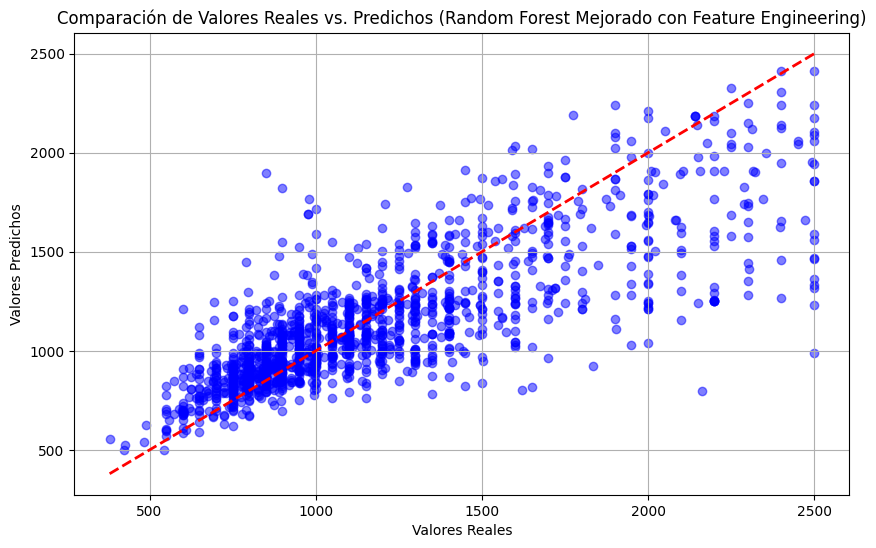

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Cargar el archivo CSV limpio
file_path = 'data_CLEAN.csv'
df_clean = pd.read_csv(file_path)

# Crear nuevas características: densidad de habitaciones (rooms per square meter)
df_clean['rooms_per_square_meter'] = df_clean['rooms'] / df_clean['square_meters']

# Aplicar una transformación logarítmica al precio para reducir el impacto de outliers
df_clean['log_price'] = np.log1p(df_clean['price'])

# Variables predictoras y objetivo (usando el log del precio)
X = df_clean[['rooms', 'bathroom', 'lift', 'terrace', 'square_meters', 'neighborhood', 'real_state', 'rooms_per_square_meter']]
y = df_clean['log_price']

# Definir las características categóricas y numéricas
categorical_features = ['neighborhood', 'real_state']
numerical_features = ['rooms', 'bathroom', 'square_meters', 'rooms_per_square_meter']

# Crear un preprocesador con OneHotEncoder y StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# Dividir el dataset en conjunto de entrenamiento y prueba (80/20) con estratificación por barrio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_clean['neighborhood'])

# Crear el modelo Random Forest en un pipeline con el preprocesador
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Definir los hiperparámetros a ajustar en RandomizedSearchCV con un rango más amplio
param_distributions = {
    'model__n_estimators': [500, 1000, 1500],
    'model__max_depth': [None, 10, 20, 30, 50],
}

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_distributions, 
    n_iter=100,  # Aumentar el número de iteraciones
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='neg_mean_squared_error', 
    random_state=42,
    n_jobs=-1
)

# Entrenar RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados y entrenar el modelo final
best_rf_model = random_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Invertir la transformación logarítmica para evaluar las métricas en escala original
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_best)

# Calcular las medidas de precisión del modelo ajustado en la escala original
rmse_best = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_best = mean_absolute_error(y_test_original, y_pred_original)
r2_best = r2_score(y_test_original, y_pred_original)

# Mostrar las nuevas medidas de precisión
precision_measures_best = {
    'RMSE': rmse_best,
    'MAE': mae_best,
    'R2 Score': r2_best
}
print("Medidas de precisión del modelo ajustado con Feature Engineering:", precision_measures_best)

# Visualizar la comparación entre los valores reales y los predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', linewidth=2, linestyle='--')
plt.title('Comparación de Valores Reales vs. Predichos (Random Forest Mejorado con Feature Engineering)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()

## Interpretación de los Resultados
RMSE y MAE:

- Estos valores indican que, en promedio, las predicciones del modelo tienen un error de alrededor de 261.49 euros (RMSE) y 186.37 euros (MAE). 
- Cuanto más bajos sean estos valores, mejor es el modelo.
- Aunque estos valores son razonables, podría haber margen para mejorar la precisión.

R2 Score:

- Un valor de 0.63 sugiere que el modelo explica el 63% de la variabilidad en los precios de las propiedades.
- Esto indica un buen ajuste, pero no es perfecto, lo que significa que hay un 37% de la variabilidad que el modelo no está capturando.